# Load data 

#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

from apricot import FacilityLocationSelection
import hdbscan
from sklearn.datasets import make_blobs

# gradient boosting trees
from xgboost import XGBRegressor

# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

import math

from common import load_data, split_data, data_selection

### Import data

In [2]:
data_dir = "../data/"
full_data = load_data(data_dir)

name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

data = full_data["data"]
inputs_perf = full_data["performance_properties"]
inputs_feat = full_data["features"]
inputs_categ = full_data["features_categorical"]
inputs_num = full_data["features_numerical"]
inputs_feat_cols = full_data["feature_columns"]
inputs_prop = full_data["input_properties"]
inputs_name = full_data["input_names"]
inputs_count = full_data["input_counts"]

random_seed = 100
system = "gcc"
train_data, test_data, _ , _ = split_data(
    data, system, inputs_count, inputs_feat_cols, random_seed
)

np.random.seed(random_seed)

valid_training_percentages = [(k+1)/10 for k in range(9)] # 0.1 -> 0.9 included

train = dict()
val = dict()

inputs_prop_categ = dict()
inputs_prop_categ["gcc"] = []
inputs_prop_categ["imagemagick"] = ["description"]
inputs_prop_categ["nodejs"] = []
inputs_prop_categ["poppler"] = []
inputs_prop_categ["xz"] = ["type"]
inputs_prop_categ["x264"] = ["category"]
inputs_prop_categ["lingeling"] = []
inputs_prop_categ["sqlite"] = []

data_with_props = dict()
props = dict()
cols = dict()

for ns in name_systems:
    props[ns] = pd.get_dummies(pd.read_csv("../data/"+ns+"/others/properties.csv").set_index("id").drop(["name"], 
                                                                                                    axis = 1), 
                           columns = inputs_prop_categ[ns]).fillna(0)
    df = data[ns, 0]
    cols[ns] = tuple(props[ns].columns)+tuple(df.columns)

for dkey in data.keys():
    ns, input_id = dkey
    df = data[dkey]
    prop_inp = tuple(props[ns].iloc[input_id])
    data_with_props[ns, input_id] = pd.DataFrame([tuple(prop_inp) + tuple(df.iloc[i]) for i in range(df.shape[0])], 
                                                 columns = cols[ns])

train_props = dict()
val_props = dict()

for dkey in data.keys():
    soft, input_id = dkey
    for p in valid_training_percentages:
        X_train, X_test = train_test_split(data[soft, input_id], train_size=p)
        train[soft, input_id, p] = X_train
        val[soft, input_id, p] = X_test
        X_train_props, X_test_props = train_test_split(data_with_props[soft, input_id], train_size=p)
        train_props[soft, input_id, p] = X_train_props
        val_props[soft, input_id, p] = X_test_props

In [3]:
train_props["x264", 0, 0.1]

,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category_Animation,category_CoverSong,category_Gaming,...,scenecut_0,scenecut_40,scenecut_None,weightb_1,weightb_None,size,kbs,fps,etime,cpu
73,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,386720.0,154.53,338.02,2.40,845.0
58,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,214092.0,85.55,273.12,2.83,943.0
155,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,270844.0,108.23,290.15,2.72,554.0
132,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,250420.0,100.07,283.60,2.76,562.0
84,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,237461.0,94.89,88.30,7.33,573.0
129,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,258298.0,103.22,278.81,2.82,508.0
74,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,185351.0,74.07,215.58,3.44,725.0
122,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,362215.0,144.74,377.10,2.23,387.0
149,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,412369.0,164.78,300.74,2.66,585.0
33,1080.0,1920.0,1080.0,0.098,0.004,0.017,0.005,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,399812.0,159.77,407.37,2.14,399.0


# Select indexes of inputs with different selection techniques

In [6]:
input_nb_list = dict()

input_nb_list["poppler"] = [2, 5, 10, 20, 50, 100, 200, 500, 800, 1000, 1300]
input_nb_list["imagemagick"] = [2, 5, 10, 20, 50, 100, 200, 500, 800]
input_nb_list["sqlite"] = [2, 5, 10, 20, 50, 75, 100, 120]
input_nb_list["lingeling"] = [2, 5, 10, 20, 50, 100, 150, 200]
input_nb_list["gcc"] = [2, 5, 10, 20, 25]
input_nb_list["nodejs"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000, 1500]
input_nb_list["xz"] = [2, 5, 10, 25, 30]
input_nb_list["x264"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000]

#conf_nb_list = dict()
#conf_nb_list["poppler"] = [2, 4, 8, 14]
#conf_nb_list["imagemagick"] = [2, 5, 10, 20, 50, 100, 200, 500, 800]
#conf_nb_list["sqlite"] = [2, 5, 10, 20, 50, 75, 100, 120]
#conf_nb_list["lingeling"] = [2, 5, 10, 20, 50, 100, 150, 200]
#conf_nb_list["gcc"] = [2, 5, 10, 20, 25]
#conf_nb_list["nodejs"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000, 1500]
#conf_nb_list["xz"] = [2, 5, 10, 25, 30]
#conf_nb_list["x264"] = [2, 5, 10, 25, 50, 100, 200, 300, 500, 1000]

inputs_indexes = dict()

for ns in name_systems:
    for nb_inp in input_nb_list[ns]:
        # pick nb_inp inputs randomly
        inputs_indexes[ns, nb_inp] = np.random.choice([k for k in range(inputs_count[ns])], nb_inp)

#### The indexes of inputs selected for the software system x264, with the hdbscan input selection technique and 10 inputs as budget

In [7]:
inputs_indexes["x264", 10]

array([1058,  415,  229, 1236,  369, 1212, 1038,   91, 1000,  628])

### Compare different (offline) input selection strategies

In [14]:
res_rq3 = dict()

for ns in name_systems:
    
    for nb_config in valid_training_percentages:
        
        list_df_tr = []
        list_df_te = []
        for i in range(1, inputs_count[ns]):
            df_tr = train_props[ns, i, nb_config]
            df_tr["input_id"] = i
            df_te = val_props[ns, i, nb_config]
            df_te["input_id"] = i
            #for col in df.columns:
            #    df[col] = (df[col]-np.mean(df[col]))/(np.std(df[col])+1e-4)
            for perf in inputs_perf[ns]:
                df_tr[perf] = (df_tr[perf]-np.mean(df_tr[perf]))/np.std(df_tr[perf])
                df_te[perf] = (df_te[perf]-np.mean(df_te[perf]))/np.std(df_te[perf])
            list_df_tr.append(df_tr)
            list_df_te.append(df_te)
        final_all_tr = pd.concat(list_df_tr).fillna(0)
        final_all_te = pd.concat(list_df_te).fillna(0)

    
        for perf in inputs_perf[ns]:
            #perf = "size"

            other_perf = [perf for perf in inputs_perf[ns]]
            other_perf.remove(perf)
            other_perf.append("input_id")

            for nb_inp in input_nb_list[ns]:
                #nb_inp = 10

                try:
                    res = []

                    for i in range(20):
                        inp_ind = inputs_indexes[ns, nb_inp]
                        s = "["
                        for ii in inp_ind:
                            s+=str(ii)+","
                        s=s[:-1]+"]"

                        df_train = final_all_tr.query("input_id in"+s).drop(other_perf, axis=1)
                        X_train = df_train.drop([perf], axis = 1)
                        y_train = df_train[perf]

                        df_test = final_all_te.query("input_id not in"+s).drop(other_perf, axis=1)
                        X_test = df_test.drop([perf], axis = 1)
                        y_test = df_test[perf]

                        dt = DecisionTreeRegressor()
                        dt.fit(X_train, y_train)
                        y_pred = dt.predict(X_test)

                        res.append(mean_absolute_error(y_pred, y_test))

                    res_rq3[ns, perf, nb_inp, nb_config] = np.mean(res)

                except:
                    print(ns, perf, nb_inp, ist)

In [15]:
res_rq3

{('nodejs', 'ops', 2, 0.1): 0.9367729706951952,
 ('nodejs', 'ops', 5, 0.1): 1.1605766752725561,
 ('nodejs', 'ops', 10, 0.1): 0.9813523569311462,
 ('nodejs', 'ops', 25, 0.1): 0.9556568447356572,
 ('nodejs', 'ops', 50, 0.1): 0.8428335712206897,
 ('nodejs', 'ops', 100, 0.1): 0.785482009880957,
 ('nodejs', 'ops', 200, 0.1): 0.7280594364420565,
 ('nodejs', 'ops', 300, 0.1): 0.7060303004408416,
 ('nodejs', 'ops', 500, 0.1): 0.6895561605659422,
 ('nodejs', 'ops', 1000, 0.1): 0.6554109064659988,
 ('nodejs', 'ops', 1500, 0.1): 0.6430863067923243,
 ('nodejs', 'ops', 2, 0.2): 0.8476137462132701,
 ('nodejs', 'ops', 5, 0.2): 0.7079519149489817,
 ('nodejs', 'ops', 10, 0.2): 0.8106935086205839,
 ('nodejs', 'ops', 25, 0.2): 0.8803380515847316,
 ('nodejs', 'ops', 50, 0.2): 0.7622638174648271,
 ('nodejs', 'ops', 100, 0.2): 0.7158782283722032,
 ('nodejs', 'ops', 200, 0.2): 0.6564299607480316,
 ('nodejs', 'ops', 300, 0.2): 0.6396200257278665,
 ('nodejs', 'ops', 500, 0.2): 0.5980425065392929,
 ('nodejs', '

In [17]:
rq3_lines = []

for mae in res_rq3.keys():
    ns, perf, nb_inp, conf = mae
    rq3_lines.append((ns, perf, nb_inp, conf, res_rq3[mae]))
    
final_rq3 = pd.DataFrame(rq3_lines, columns = ["soft", "perf", "nb_inputs", "nb_config", "mae"])
final_rq3.to_csv("../results/RQ3_data.csv")

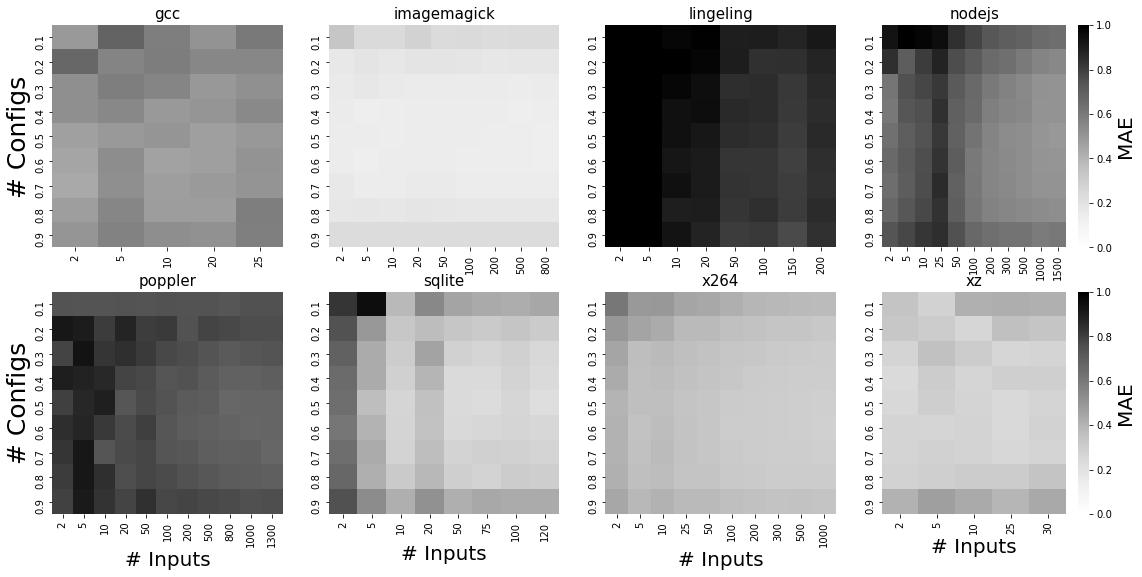

In [78]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(19, 9)

linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
colors = ["gainsboro", "silver", "gray", "dimgray"]
markers = ['o', 's', 'p', 'x']

for l in range(len(name_systems)):
    ns = sorted(name_systems)[l]
    mat = np.zeros(len(valid_training_percentages)*len(input_nb_list[ns])).reshape(len(valid_training_percentages),
                                                                              len(input_nb_list[ns]))
    for i in range(len(valid_training_percentages)):
        nb_config = valid_training_percentages[i]
        for j in range(len(input_nb_list[ns])):
            nb_inp = input_nb_list[ns][j]
            mat[i][j] = np.mean([res_rq3[k] for k in res_rq3.keys() if k[2]==nb_inp and k[0]==ns and k[3] == nb_config])
    if l%4==3:
        sns.heatmap(mat, vmin=0, vmax=1, cmap = "Greys", ax = axs[int(l/4), l%4], 
                    yticklabels=valid_training_percentages, xticklabels=input_nb_list[ns],
                   cbar_kws={'label': 'MAE'})
        axs[int(l/4), l%4].figure.axes[-1].yaxis.label.set_size(20)
        axs[int(l/4), l%4].tick_params(axis='x', labelrotation= 90)
    else:
        sns.heatmap(mat, vmin=0, vmax=1, cbar=False, cmap = "Greys", ax = axs[int(l/4), l%4], 
                    yticklabels=valid_training_percentages, xticklabels=input_nb_list[ns])
        axs[int(l/4), l%4].tick_params(axis='x', labelrotation= 90)
    # Draw a nested boxplot to show bills by day and time
    axs[int(l/4), l%4].set_title(ns, fontsize =15)
    #axs[int(l/4), l%4].set_xticks([k +0.5 for k in range(len(valid_training_percentages))], valid_training_percentages)
    #axs[int(l/4), l%4].set_yticks([k +0.5 for k in range(len(input_nb_list[ns]))], input_nb_list[ns])
    #axs[l%4, int(l/4)].set_ylim(0, np.percentile(final_rq2.query("soft=='"+soft+"'")["val"], 95))
    if l>=4:
        axs[int(l/4), l%4].set_xlabel("# Inputs", size = 20)
    else:
        axs[int(l/4), l%4].set_xlabel("")
    if l%4==0:
        axs[int(l/4), l%4].set_ylabel("# Configs", size = 25)
        
# Arrow
# plt.arrow(x = 4.5, y = 2, dx= 0, dy = -0.3, head_width = 0.15, head_length = .1, color="orange")
# plt.text(s = "Better", x = 4, y = 1.95, size = 20, color = 'orange')

#plt.xticks(size = 20)
#plt.yticks(size = 20)
plt.savefig("../results/RQ3_eval_all.png")
plt.show()